Requirement
1. Connect to local runtime
2. Dataset https://drive.google.com/drive/folders/1I4W_VtLwKy84YTY2Sbfk-DQ2F7Pi6jUp?usp=share_link

References:

https://ieeexplore.ieee.org/document/9627165

https://github.com/danfenghong/IEEE_TGRS_SpectralFormer

In [ ]:
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
from scipy.io import loadmat
from scipy.io import savemat
from torch import optim
from torch.autograd import Variable
from vit_pytorch import ViT
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time
import os

In [ ]:
def chooose_train_and_test_point(train_data, test_data, true_data, num_classes):
    number_train = []
    pos_train = {}
    number_test = []
    pos_test = {}
    number_true = []
    pos_true = {}
    #-------------------------for train data------------------------------------
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(train_data==(i+1))
        number_train.append(each_class.shape[0])
        pos_train[i] = each_class

    total_pos_train = pos_train[0]
    for i in range(1, num_classes):
        total_pos_train = np.r_[total_pos_train, pos_train[i]] #(695,2)
    total_pos_train = total_pos_train.astype(int)
    #--------------------------for test data------------------------------------
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(test_data==(i+1))
        number_test.append(each_class.shape[0])
        pos_test[i] = each_class

    total_pos_test = pos_test[0]
    for i in range(1, num_classes):
        total_pos_test = np.r_[total_pos_test, pos_test[i]] #(9671,2)
    total_pos_test = total_pos_test.astype(int)
    #--------------------------for true data------------------------------------
    for i in range(num_classes+1):
        each_class = []
        each_class = np.argwhere(true_data==i)
        number_true.append(each_class.shape[0])
        pos_true[i] = each_class

    total_pos_true = pos_true[0]
    for i in range(1, num_classes+1):
        total_pos_true = np.r_[total_pos_true, pos_true[i]]
    total_pos_true = total_pos_true.astype(int)

    return total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true

In [ ]:
def mirror_hsi(height,width,band,input_normalize,patch=5):
    padding=patch//2
    mirror_hsi=np.zeros((height+2*padding,width+2*padding,band),dtype=float)
    mirror_hsi[padding:(padding+height),padding:(padding+width),:]=input_normalize
    for i in range(padding):
        mirror_hsi[padding:(height+padding),i,:]=input_normalize[:,padding-i-1,:]
    for i in range(padding):
        mirror_hsi[padding:(height+padding),width+padding+i,:]=input_normalize[:,width-1-i,:]
    for i in range(padding):
        mirror_hsi[i,:,:]=mirror_hsi[padding*2-i-1,:,:]
    for i in range(padding):
        mirror_hsi[height+padding+i,:,:]=mirror_hsi[height+padding-1-i,:,:]

    print("**************************************************")
    print("patch is : {}".format(patch))
    print("mirror_image shape : [{0},{1},{2}]".format(mirror_hsi.shape[0],mirror_hsi.shape[1],mirror_hsi.shape[2]))
    print("**************************************************")
    return mirror_hsi

In [ ]:
def gain_neighborhood_pixel(mirror_image, point, i, patch=5):
    x = point[i,0]
    y = point[i,1]
    temp_image = mirror_image[x:(x+patch),y:(y+patch),:]
    return temp_image

def gain_neighborhood_band(x_train, band, band_patch, patch=5):
    nn = band_patch // 2
    pp = (patch*patch) // 2
    x_train_reshape = x_train.reshape(x_train.shape[0], patch*patch, band)
    x_train_band = np.zeros((x_train.shape[0], patch*patch*band_patch, band),dtype=float)
    x_train_band[:,nn*patch*patch:(nn+1)*patch*patch,:] = x_train_reshape
    for i in range(nn):
        if pp > 0:
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,:i+1] = x_train_reshape[:,:,band-i-1:]
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,i+1:] = x_train_reshape[:,:,:band-i-1]
        else:
            x_train_band[:,i:(i+1),:(nn-i)] = x_train_reshape[:,0:1,(band-nn+i):]
            x_train_band[:,i:(i+1),(nn-i):] = x_train_reshape[:,0:1,:(band-nn+i)]
    for i in range(nn):
        if pp > 0:
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,:band-i-1] = x_train_reshape[:,:,i+1:]
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,band-i-1:] = x_train_reshape[:,:,:i+1]
        else:
            x_train_band[:,(nn+1+i):(nn+2+i),(band-i-1):] = x_train_reshape[:,0:1,:(i+1)]
            x_train_band[:,(nn+1+i):(nn+2+i),:(band-i-1)] = x_train_reshape[:,0:1,(i+1):]
    return x_train_band

In [ ]:
def train_and_test_data(mirror_image, band, train_point, test_point, true_point, patch=5, band_patch=3):
    x_train = np.zeros((train_point.shape[0], patch, patch, band), dtype=float)
    x_test = np.zeros((test_point.shape[0], patch, patch, band), dtype=float)
    x_true = np.zeros((true_point.shape[0], patch, patch, band), dtype=float)
    for i in range(train_point.shape[0]):
        x_train[i,:,:,:] = gain_neighborhood_pixel(mirror_image, train_point, i, patch)
    for j in range(test_point.shape[0]):
        x_test[j,:,:,:] = gain_neighborhood_pixel(mirror_image, test_point, j, patch)
    for k in range(true_point.shape[0]):
        x_true[k,:,:,:] = gain_neighborhood_pixel(mirror_image, true_point, k, patch)
    print("x_train shape = {}, type = {}".format(x_train.shape,x_train.dtype))
    print("x_test  shape = {}, type = {}".format(x_test.shape,x_test.dtype))
    print("x_true  shape = {}, type = {}".format(x_true.shape,x_test.dtype))
    print("**************************************************")


    x_train_band = gain_neighborhood_band(x_train, band, band_patch, patch)
    x_test_band = gain_neighborhood_band(x_test, band, band_patch, patch)
    x_true_band = gain_neighborhood_band(x_true, band, band_patch, patch)
    print("x_train_band shape = {}, type = {}".format(x_train_band.shape,x_train_band.dtype))
    print("x_test_band  shape = {}, type = {}".format(x_test_band.shape,x_test_band.dtype))
    print("x_true_band  shape = {}, type = {}".format(x_true_band.shape,x_true_band.dtype))
    print("**************************************************")
    return x_train_band, x_test_band, x_true_band

In [ ]:
def train_and_test_label(number_train, number_test, number_true, num_classes):
    y_train = []
    y_test = []
    y_true = []
    for i in range(num_classes):
        for j in range(number_train[i]):
            y_train.append(i)
        for k in range(number_test[i]):
            y_test.append(i)
    for i in range(num_classes+1):
        for j in range(number_true[i]):
            y_true.append(i)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_true = np.array(y_true)
    print("y_train: shape = {} ,type = {}".format(y_train.shape,y_train.dtype))
    print("y_test: shape = {} ,type = {}".format(y_test.shape,y_test.dtype))
    print("y_true: shape = {} ,type = {}".format(y_true.shape,y_true.dtype))
    print("**************************************************")
    return y_train, y_test, y_true

In [ ]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt
#-------------------------------------------------------------------------------
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res, target, pred.squeeze()
#-------------------------------------------------------------------------------
# train model
def train_epoch(model, train_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        optimizer.zero_grad()
        batch_pred = model(batch_data)
        loss = criterion(batch_pred, batch_target)
        loss.backward()
        optimizer.step()

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
    return top1.avg, objs.avg, tar, pre
#-------------------------------------------------------------------------------
# validate model
def valid_epoch(model, valid_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(valid_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        batch_pred = model(batch_data)

        loss = criterion(batch_pred, batch_target)

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())

    return tar, pre

def test_epoch(model, test_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(test_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        batch_pred = model(batch_data)

        _, pred = batch_pred.topk(1, 1, True, True)
        pp = pred.squeeze()
        pre = np.append(pre, pp.data.cpu().numpy())
    return pre
#-------------------------------------------------------------------------------
def output_metric(tar, pre):
    matrix = confusion_matrix(tar, pre)
    OA, AA_mean, Kappa, AA = cal_results(matrix)
    return OA, AA_mean, Kappa, AA
#-------------------------------------------------------------------------------
def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=float)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
cudnn.deterministic = True
cudnn.benchmark = False

In [ ]:
folder = 'G:/My Drive/group project/dataset'
data = loadmat(folder+'/IndianPine.mat')
color_mat = loadmat(folder+'/color.mat')
TR = data['TR']
TE = data['TE']
input = data['input'] #(145,145,200)
label = TR + TE
num_classes = np.max(TR)

color_mat_list = list(color_mat)
color_matrix = color_mat[color_mat_list[3]] #(17,3)
# normalize data by band norm
input_normalize = np.zeros(input.shape)
for i in range(input.shape[2]):
    input_max = np.max(input[:,:,i])
    input_min = np.min(input[:,:,i])
    input_normalize[:,:,i] = (input[:,:,i]-input_min)/(input_max-input_min)
# data size
height, width, band = input.shape
print("height={0},width={1},band={2}".format(height, width, band))

height=145,width=145,band=200


In [ ]:
np.unique(TE)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

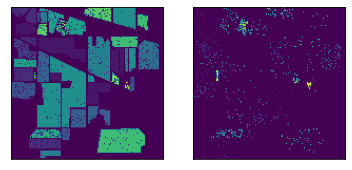

In [ ]:
plt.subplot(1,2,1)
plt.imshow(TE)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(TR)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# obtain train and test data
patches=7
band_patches=3
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = chooose_train_and_test_point(TR, TE, label, num_classes)
mirror_image = mirror_hsi(height, width, band, input_normalize, patch=patches)
x_train_band, x_test_band, x_true_band = train_and_test_data(mirror_image, band, total_pos_train, total_pos_test, total_pos_true, patch=patches, band_patch=band_patches)
y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)
#-------------------------------------------------------------------------------
# load data
x_train=torch.from_numpy(x_train_band.transpose(0,2,1)).type(torch.FloatTensor) #[695, 200, 7, 7]
y_train=torch.from_numpy(y_train).type(torch.LongTensor) #[695]
Label_train=Data.TensorDataset(x_train,y_train)
x_test=torch.from_numpy(x_test_band.transpose(0,2,1)).type(torch.FloatTensor) # [9671, 200, 7, 7]
y_test=torch.from_numpy(y_test).type(torch.LongTensor) # [9671]
Label_test=Data.TensorDataset(x_test,y_test)
x_true=torch.from_numpy(x_true_band.transpose(0,2,1)).type(torch.FloatTensor)
y_true=torch.from_numpy(y_true).type(torch.LongTensor)
Label_true=Data.TensorDataset(x_true,y_true)

label_train_loader=Data.DataLoader(Label_train,batch_size=64,shuffle=True)
label_test_loader=Data.DataLoader(Label_test,batch_size=64,shuffle=True)
label_true_loader=Data.DataLoader(Label_true,batch_size=100,shuffle=False)

#-------------------------------------------------------------------------------

**************************************************
patch is : 7
mirror_image shape : [151,151,200]
**************************************************
x_train shape = (695, 7, 7, 200), type = float64
x_test  shape = (9671, 7, 7, 200), type = float64
x_true  shape = (21025, 7, 7, 200), type = float64
**************************************************
x_train_band shape = (695, 147, 200), type = float64
x_test_band  shape = (9671, 147, 200), type = float64
x_true_band  shape = (21025, 147, 200), type = float64
**************************************************
y_train: shape = (695,) ,type = int32
y_test: shape = (9671,) ,type = int32
y_true: shape = (21025,) ,type = int32
**************************************************


In [ ]:
# create model
model = ViT(
    image_size = patches,
    near_band = band_patches,
    num_patches = band,
    num_classes = 16,
    dim = 64,
    depth = 5,
    heads = 4,
    mlp_dim = 8,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = 'CAF'
)
model = model.cuda()
# criterion
criterion = nn.CrossEntropyLoss().cuda()
# optimizer
epoches = 600
test_freq =5

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epoches//10, gamma=0.9)

In [ ]:
#training
tic = time.time()
for epoch in range(epoches):
    scheduler.step()

    # train model
    model.train()
    train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
    OA1, AA_mean1, Kappa1, AA1 = output_metric(tar_t, pre_t)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}"
                    .format(epoch+1, train_obj, train_acc))


    if (epoch % test_freq == 0) | (epoch == epoches - 1):
        model.eval()
        tar_v, pre_v = valid_epoch(model, label_test_loader, criterion, optimizer)
        OA2, AA_mean2, Kappa2, AA2 = output_metric(tar_v, pre_v)

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

print("Final result:")
print("OA: {:.4f} | AA: {:.4f} | Kappa: {:.4f}".format(OA2, AA_mean2, Kappa2))
print(AA2)
print("**************************************************")

C:\Users\ilham\anaconda3\envs\ilham\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 001 train_loss: 2.7950 train_acc: 7.7698
Epoch: 002 train_loss: 2.5461 train_acc: 15.9712
Epoch: 003 train_loss: 2.2945 train_acc: 19.8561
Epoch: 004 train_loss: 2.1242 train_acc: 26.1870
Epoch: 005 train_loss: 2.0038 train_acc: 30.7914
Epoch: 006 train_loss: 1.9343 train_acc: 31.9424
Epoch: 007 train_loss: 1.8782 train_acc: 35.2518
Epoch: 008 train_loss: 1.8321 train_acc: 38.1295
Epoch: 009 train_loss: 1.7696 train_acc: 37.8417
Epoch: 010 train_loss: 1.7063 train_acc: 42.8777
Epoch: 011 train_loss: 1.6446 train_acc: 39.2806
Epoch: 012 train_loss: 1.5748 train_acc: 42.4460
Epoch: 013 train_loss: 1.5111 train_acc: 45.7554
Epoch: 014 train_loss: 1.4315 train_acc: 50.9353
Epoch: 015 train_loss: 1.4049 train_acc: 49.6403
Epoch: 016 train_loss: 1.3552 train_acc: 49.7842
Epoch: 017 train_loss: 1.3447 train_acc: 52.3741
Epoch: 018 train_loss: 1.2662 train_acc: 52.9496
Epoch: 019 train_loss: 1.2432 train_acc: 54.3885
Epoch: 020 train_loss: 1.2113 train_acc: 55.6835
Epoch: 021 train_loss

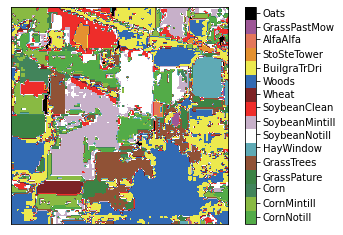

In [ ]:
#test
model.eval()
tar_v, pre_v = valid_epoch(model, label_test_loader, criterion, optimizer)
OA2, AA_mean2, Kappa2, AA2 = output_metric(tar_v, pre_v)

# output classification maps
pre_u = test_epoch(model, label_true_loader, criterion, optimizer)
prediction_matrix = np.zeros((height, width), dtype=float)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i,0], total_pos_true[i,1]] = pre_u[i] + 1
plt.subplot(1,1,1)
ax = plt.imshow(prediction_matrix, colors.ListedColormap(color_matrix))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(ticks=[1.5,2.5,3.5,4.3,5.3,6.3,7.2,8.1,9.1,
                                10,10.9,11.8,12.8,13.8,14.6,15.6])
cbar.ax.set_yticklabels(['CornNotill', 'CornMintill', 'Corn', 'GrassPature',
'GrassTrees', 'HayWindow', 'SoybeanNotill', 'SoybeanMintill',
'SoybeanClean', 'Wheat', 'Woods', 'BuilgraTrDri',
'StoSteTower', 'AlfaAlfa', 'GrassPastMow', 'Oats'])
plt.show()

In [ ]:
np.unique(prediction_matrix)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.])